In [2]:
!pip install wget

  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
from pytorch_tabnet import tab_network
from pytorch_tabnet.tab_model import Model

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

# Download ForestCoverType dataset

In [18]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
os.chdir('/mnt/nwilairat/training/')
tmp_out = Path(os.getcwd()+'/Data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/Data/'+dataset_name+'.csv')

In [19]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    


File already exists.


# Load data and split
Same split as in original paper

In [20]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [21]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [22]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [23]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


train[target] = train[target].astype(int)-1

# Network parameters

In [24]:
num_workers= 5
LR = 2e-2
batch_size = 16384 #64
mini_batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
network_params = {"input_dim" : len(features),
                  "n_d" : 32,
                  "n_a" : 32,
                  "n_independent": 2,
                  "n_shared": 2,
                  "n_steps": 6,
                  "gamma": 1.5,
                  "output_dim" :7,
                  "momentum": 0.3,
                  "cat_idxs":cat_idxs,
                  "cat_dims": cat_dims,
                  "cat_emb_dim": 1,
                  "virtual_batch_size": mini_batch_size,
}

description = f"test_TabNet_LR_{LR}_BS_{batch_size}_DS_{dataset_name}"
description += f"_miniBS_{mini_batch_size}"
description += f"_nd_{network_params['n_d']}"
description += f"_na_{network_params['n_a']}"
description += f"_nsteps_{network_params['n_steps']}"
description += f"_gamma_{network_params['gamma']}"
description += f"_momentum_{network_params['momentum']}"

In [26]:
my_scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"gamma": 0.95,
                    "step_size": 20}

training_params = {"model_name": description,
                   "lambda_sparse": 1e-4,
                   "lr":LR,
                   "patience": 60,
                   "optimizer_fn":torch.optim.Adam,
                   "scheduler_fn": my_scheduler,
                   "scheduler_params":scheduler_params,
                   "max_epochs": 800,
                   "batch_size": batch_size,
                   "clip_value": 2.0,
                   "device":device
                  }

# Training

In [27]:
X_train = train.iloc[train_indices][features].values
y_train = train.iloc[train_indices][target].values

X_valid = train.iloc[valid_indices][features].values
y_valid = train.iloc[valid_indices][target].values

X_test = train.iloc[test_indices][features].values
y_test = train.iloc[test_indices][target].values

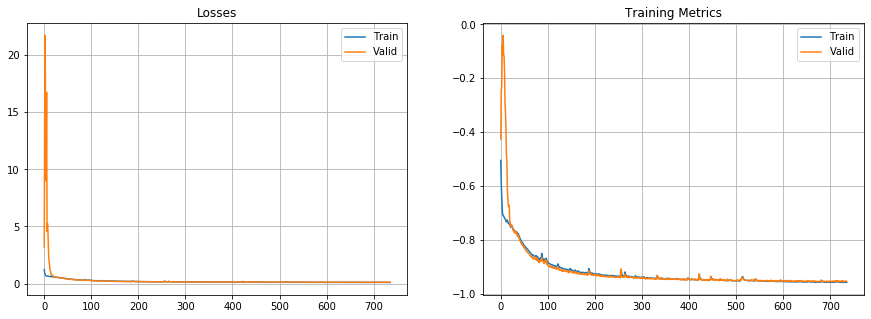

In [28]:
network = tab_network.TabNet
model = Model()


model.def_network(network, **network_params)
model.set_params(**training_params)

model.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid
) 

In [29]:
model.load_best_model()

preds, M_explain, masks = model.predict_proba(X_test)

y_true = y_test

test_acc = accuracy_score(y_pred=np.argmax(preds, axis=1), y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {model.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : -0.9558594783686273
FINAL TEST SCORE FOR forest-cover-type : 0.9570923298021565


# XGB

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-merror:0.218469
Will train until validation_0-merror hasn't improved in 40 rounds.
[10]	validation_0-merror:0.194363
[20]	validation_0-merror:0.183817
[30]	validation_0-merror:0.177046
[40]	validation_0-merror:0.170682
[50]	validation_0-merror:0.161917
[60]	validation_0-merror:0.156154
[70]	validation_0-merror:0.15059
[80]	validation_0-merror:0.145504
[90]	validation_0-merror:0.141838
[100]	validation_0-merror:0.136681
[110]	validation_0-merror:0.131892
[120]	validation_0-merror:0.126948
[130]	validation_0-merror:0.123366
[140]	validation_0-merror:0.118332
[150]	validation_0-merror:0.11433
[160]	validation_0-merror:0.110451
[170]	validation_0-merror:0.106127
[180]	validation_0-merror:0.102893
[190]	validation_0-merror:0.099318
[200]	validation_0-merror:0.0962
[210]	validation_0-merror:0.093774
[220]	validation_0-merror:0.090488
[230]	validation_0-merror:0.088133
[240]	validation_0-merror:0.085273
[250]	validation_0-merror:0.082982
[260]	validation_0-merror:0.080523
[27

In [32]:
preds_valid = np.array(clf.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1), y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1), y_true=y_test)
print(test_acc)

0.9597255658751621
0.9604227085359242
